# Readmission Analysis of a Diabetes Patient

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.stats import norm
from scipy import optimize
from svm_utils import *
from sklearn import preprocessing
from sklearn.metrics import *
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve

import time

In [3]:
df = pd.read_csv('diabetic_data.csv')
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [4]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

**<center>Feature Description</center>**

| Features | Description |
| --- | --- |
| Encounter ID | Unique identifier of an encounter |
| Patient number | Unique identifier of a patient |
| Race | Values: Caucasian, Asian, African American, Hispanic, Other |
| Gender | Values: male, female, unknown/invalid |
| Age | 10-year age groups from 0-10 to 90-100 |
| Weight | Weight of patient in pounds. |
| Admission Type ID | 7 unique values identifying the type of admission |
| Discharge Disposition ID | 29 distinct values corresponding to discharge status |
| Admission Source ID | 25 unique values specifying the type of admission source |
| Time in hospital | Number of days between admission and discharge |
| Payer Code | 23 unique values specifying the various payer codes |
| Medical Specialty | 84 unique values corresponding to medical specialty of admitting physician |
| Number of Lab Procedures | Number of lab tests performed during the encounter |
| Number of Procedures | Number of procedures (other than lab tests) performed during the encounter |
| Number of Medications | Number of distinct generic names administered during the encounter |
| Number of Outpatient Visits | Number of outpatient visits of the patient in the year preceding the encounter |
| Number of Emergency Visits | Number of emergency visits of the patient in the year preceding the encounter |
| Number of Inpatient Visits | Number of inpatient visits of the patient in the year preceding the encounter |
| Diagnosis 1 | Primary diagnosis (coded as first three digits of ICD9); 848 distinct values |
| Diagnosis 2 | Secondary diagnosis (coded as first three digits of ICD9); 923 distinct values |
| Diagnosis 3 | Additional secondary diagnosis (coded as first three digits of ICD9); 954 distinct values |
| Number of Diagnoses | Number of diagnoses entered to the system |
| Glucose Serum Test Result | Indicates the blood sugar level after an overnight fast |
| A1c Result | Indicates the HbA1c test result |
| 24 features for Medications | Indicates whether the given drug was prescribed or there was a change in medication |
| Change of Medications | Indicates if there was a change in diabetic medications |
| Diabetes Medications | Indicates if there was any diabetic medication prescribed |
| Readmitted (Target Variable) | Days to inpatient readmission |


In [5]:
#print the shape of data
print('Shape of data:',df.shape)

Shape of data: (101766, 50)


## Exploratory Data Analysis

**Target Variable**

In [7]:
print('Total number of unique values in data each readmitted column:',df['readmitted'].nunique())
print('Unique values in readmitted column:',df['readmitted'].unique())

Total number of unique values in data each readmitted column: 3
Unique values in readmitted column: ['NO' '>30' '<30']


In [8]:
print('Total readmitted values:',df['readmitted'].value_counts())

Total readmitted values: NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64


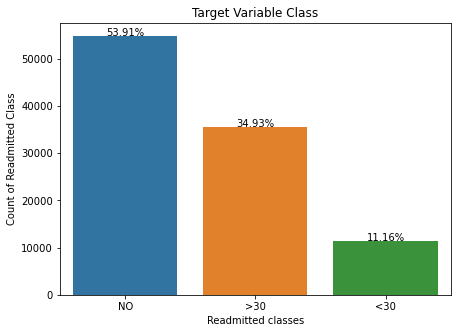

In [9]:
plt.figure(figsize = (7, 5))
ax = sns.countplot(x='readmitted',data=df)
plt.xlabel('Readmitted classes')
plt.ylabel('Count of Readmitted Class')
total = len(df['readmitted'])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center")
plt.title("Target Variable Class")
plt.show()

We observe that there is a lot of imbalance in the target variable classes. We know that the class >30 signifies that the patient was readmitted in more than 30 days and <30 signifies that the patient was readmitted in less than 30 days. Therefore, we combine these 2 classes as class 1 (patient was readmitted). On the other hand, class ‘No’ means that the patient was not readmitted at all and we call it class 0 (patient was not readmitted).

In [10]:
#create a new column called readmitted_class
df['readmitted_class'] = df['readmitted'].apply(lambda x: 0 if x == 'NO' else 1)

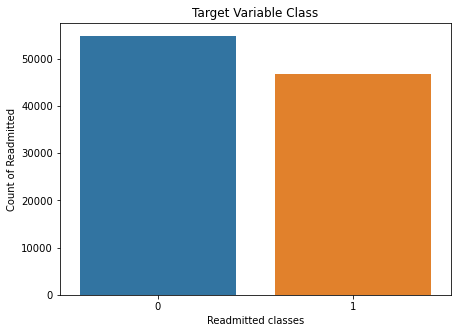

In [11]:
#plot a bar graph for readmitted values using seaborn in percentage
plt.figure(figsize = (7, 5))
sns.countplot(x='readmitted_class',data=df)
#x-axis label
plt.xlabel('Readmitted classes')
#y-axis label
plt.ylabel('Count of Readmitted')
#calculate percentage
total = len(df['readmitted_class'])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center")
plt.title("Target Variable Class")
plt.show()

**Numerical Columns**

In [12]:
df._get_numeric_data()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted_class
0,2278392,8222157,6,25,1,1,41,0,1,0,0,0,1,0
1,149190,55629189,1,1,7,3,59,0,18,0,0,0,9,1
2,64410,86047875,1,1,7,2,11,5,13,2,0,1,6,0
3,500364,82442376,1,1,7,2,44,1,16,0,0,0,7,0
4,16680,42519267,1,1,7,1,51,0,8,0,0,0,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,1,3,7,3,51,0,16,0,0,0,9,1
101762,443847782,74694222,1,4,5,5,33,3,18,0,0,1,9,0
101763,443854148,41088789,1,1,7,1,53,0,9,1,0,0,13,0
101764,443857166,31693671,2,3,7,10,45,2,21,0,0,1,9,0


We observe that the dataset has 13 numerical columns. However, the columns admission_type_id, discharge_disposition_id, admission_source_id are mappings to various categories. Below are the tables corresponding to these columns and what each value specifies.

| | Admission Type ID |
| -- | -- |
| 1 | Emergency |
| 2 | Urgent |
| 3 | Elective |
| 4 | Newborn |
| 5 | Not Available |
| 6 | Null |
| 7 | Trauma Center |
| 8 | Not Mapped |

In [13]:
#map the admission_type_id column with admission_type_description column
#and put it in a new column called admission_type
df['admission_type'] = df['admission_type_id'].map({1:'Emergency',
                                                    2:'Urgent',
                                                    3:'Elective',
                                                    4:'Newborn',
                                                    5:'Not Available',
                                                    6:'NULL',
                                                    7:'Trauma Center',
                                                    8:'Not Mapped'})

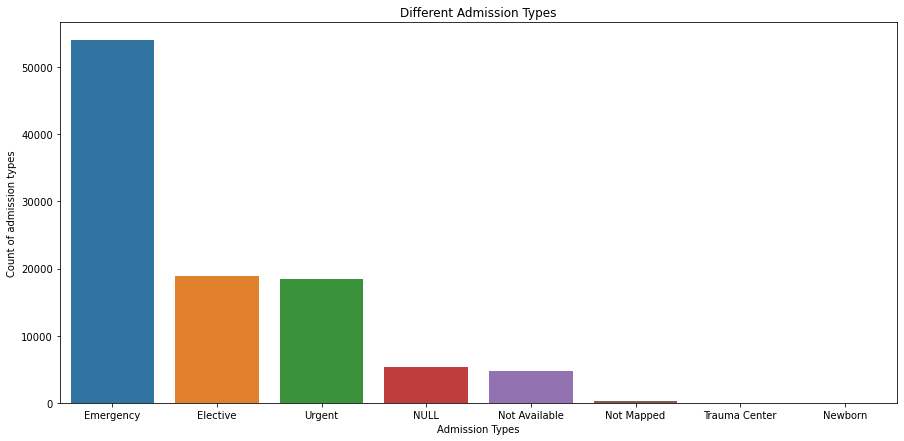

In [14]:
#plot a bar graph for admission_id using seaborn
plt.figure(figsize = (15, 7))
sns.barplot(x=df['admission_type'].value_counts().index,   y=df['admission_type'].value_counts())
plt.title("Different Admission Types")
plt.xlabel("Admission Types")
plt.ylabel("Count of admission types")
plt.show()

| | Discharge Disposition ID |
| -- | -- |
|1|Discharged to home|
|2|Discharged/transferred to another short term hospital|
|3|Discharged/transferred to SNF|
|4|Discharged/transferred to ICF|
|5|Discharged/transferred to another type of inpatient care institution|
|6|Discharged/transferred to home with home health service|
|7|Left AMA|
|8|Discharged/transferred to home under care of Home IV provider|
|9|Admitted as an inpatient to this hospital|
|10|Neonate discharged to another hospital for neonatal aftercare|
|11|Expired|
|12|Still patient or expected to return for outpatient services|
|13|Hospice / home|
|14|Hospice / medical facility|
|15|Discharged/transferred within this institution to Medicare approved swing bed|
|16|Discharged/transferred/referred another institution for outpatient services|
|17|Discharged/transferred/referred to this institution for outpatient services|
|18|Null|
|19|Expired at home, Medicaid only, hospice|
|20|Expired in a medical facility, Medicaid only, hospice|
|21|Expired, place unknown, Medicaid only, hospice|
|22|Discharged/transferred to another rehab fac including rehab units of a hospital|
|23|Discharged/transferred to a long term care hospital|
|24|Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare|
|25|Not Mapped|
|26|Unknown/Invalid|
|27|Discharged/transferred to a federal health care facility|
|28|Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital|
|29|Discharged/transferred to a Critical Access Hospital (CAH)|
|30|Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere|

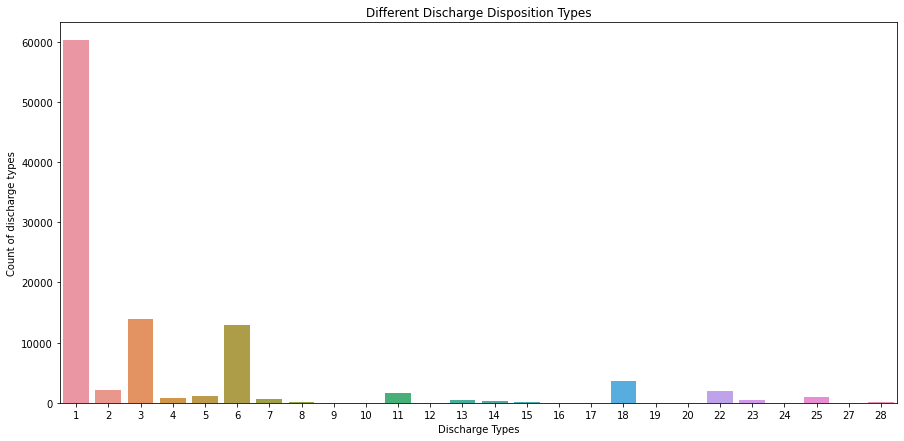

In [15]:
#plot a bar graph for discharge_disposition_id using seaborn
plt.figure(figsize = (15, 7))
sns.countplot(df['discharge_disposition_id'])
plt.title("Different Discharge Disposition Types")
plt.xlabel("Discharge Types")
plt.ylabel("Count of discharge types")
plt.show()

||Admission Source ID|
| -- | -- |
|1|Physician Referral|
|2|Clinic Referral|
|3|HMO Referral|
|4|Transfer from a hospital|
|5|Transfer from a Skilled Nursing Facility (SNF)|
|6|Transfer from another health care facility|
|7|Emergency Room|
|8|Court/Law Enforcement|
|9|Not Available|
|10|Transfer from critial access hospital|
|11|Normal Delivery|
|12|Premature Delivery|
|13|Sick Baby|
|14|Extramural Birth|
|15|Not Available|
|17|Null|
|18|Transfer From Another Home Health Agency|
|19|Readmission to Same Home Health Agency|
|20|Not Mapped|
|21|Unknown/Invalid|
|22|Transfer from hospital inpt/same fac reslt in a sep claim|
|23|Born inside this hospital|
|24|Born outside this hospital
|25|Transfer from Ambulatory Surgery Center|
|26|Transfer from Hospice|

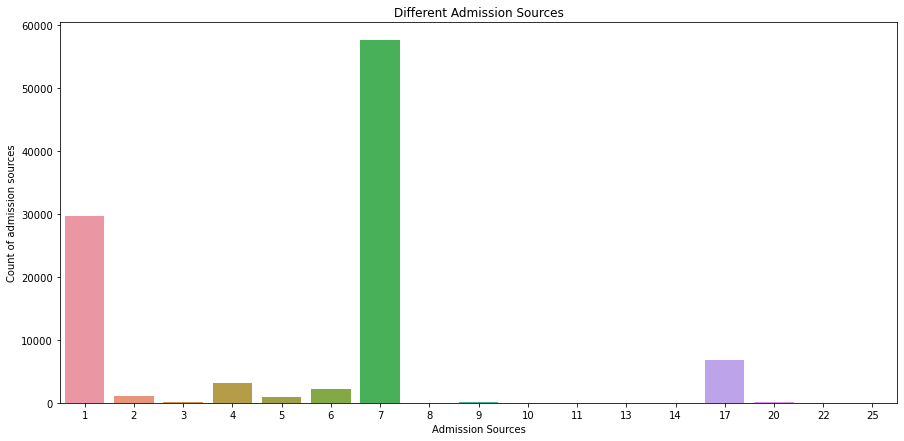

In [16]:
#plot a bar graph for admission_source_id using seaborn
plt.figure(figsize = (15, 7))
sns.countplot(df['admission_source_id'])
plt.title("Different Admission Sources")
plt.xlabel("Admission Sources")
plt.ylabel("Count of admission sources")
plt.show()

The column ‘time_in_hosptital’ tell us how many days the patient spent at the hospital.

In [17]:
#mean of time in hospital
print('Mean of time in hospital:',df['time_in_hospital'].mean())

Mean of time in hospital: 4.395986871843248


We observe the distribution of this variable, and we conclude that the average number of days between hospital admission and discharge is around 4 days.

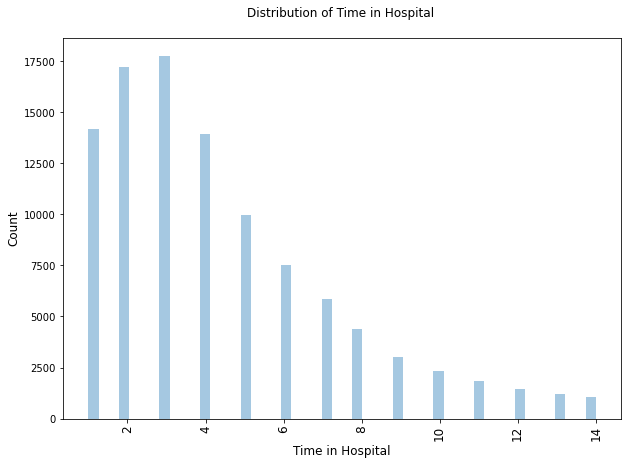

In [18]:
#plot time in hospital using seaborn
plt.figure(figsize = (10, 7))
ax = sns.distplot(df['time_in_hospital'],kde=False)
plt.xlabel('Time in Hospital', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Count', size = 12)
plt.title('Distribution of Time in Hospital \n', size = 12)
plt.show()

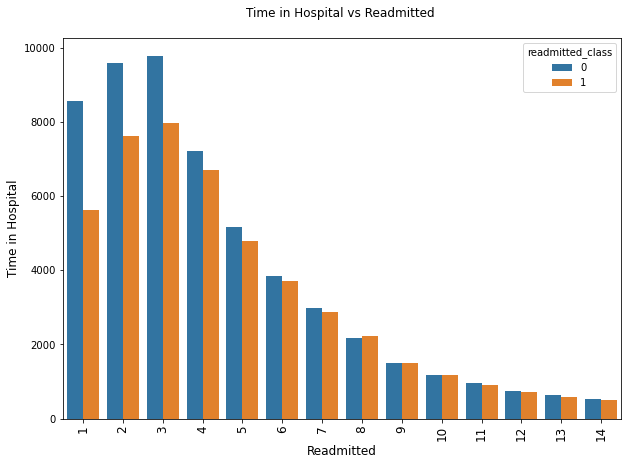

In [19]:
#plot relationship between time in hospital and readmitted using seaborn
plt.figure(figsize = (10, 7))
ax = sns.countplot(x='time_in_hospital',hue = 'readmitted_class',data=df)
plt.xlabel('Readmitted', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Time in Hospital', size = 12)
plt.title('Time in Hospital vs Readmitted \n', size = 12)
plt.show()

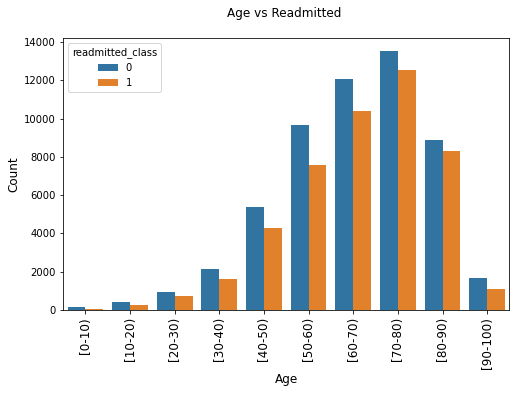

In [22]:
#plot age of patient using seaborn
plt.figure(figsize = (8, 5))
sns.countplot(df['age'], hue = df['readmitted_class'])
plt.xlabel('Age', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Count', size = 12)
plt.title('Age vs Readmitted \n', size = 12)
plt.show()

Most of the patients that have diabetes lie in the 50 to 90-year span.

## Data Cleaning and Processing

**Missing Values**

In [23]:
#total null values in data each column  
print('Total null values in data each column:',df.isnull().sum())

Total null values in data each column: encounter_id                0
patient_nbr                 0
race                        0
gender                      0
age                         0
weight                      0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
payer_code                  0
medical_specialty           0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
t

We observe that there are no missing values in the dataset. However, there are a lot of '?' values present which means they can be considered as missing values from the dataset.

In [24]:
#total count of ? in data each column
missing_count = df.eq('?').sum()
missing_percent = round(df.eq('?').sum() * 100 / len(df), 2)
missing_data = pd.DataFrame(missing_count)
missing_data.columns = ["missing_count"]
missing_data['missing_percent']  = missing_percent
missing_data = missing_data.sort_values('missing_percent', ascending=False)
missing_data.head(10)

,missing_count,missing_percent
weight,98569,96.86
medical_specialty,49949,49.08
payer_code,40256,39.56
race,2273,2.23
diag_3,1423,1.40
diag_2,358,0.35
diag_1,21,0.02
encounter_id,0,0.00
examide,0,0.00
tolbutamide,0,0.00


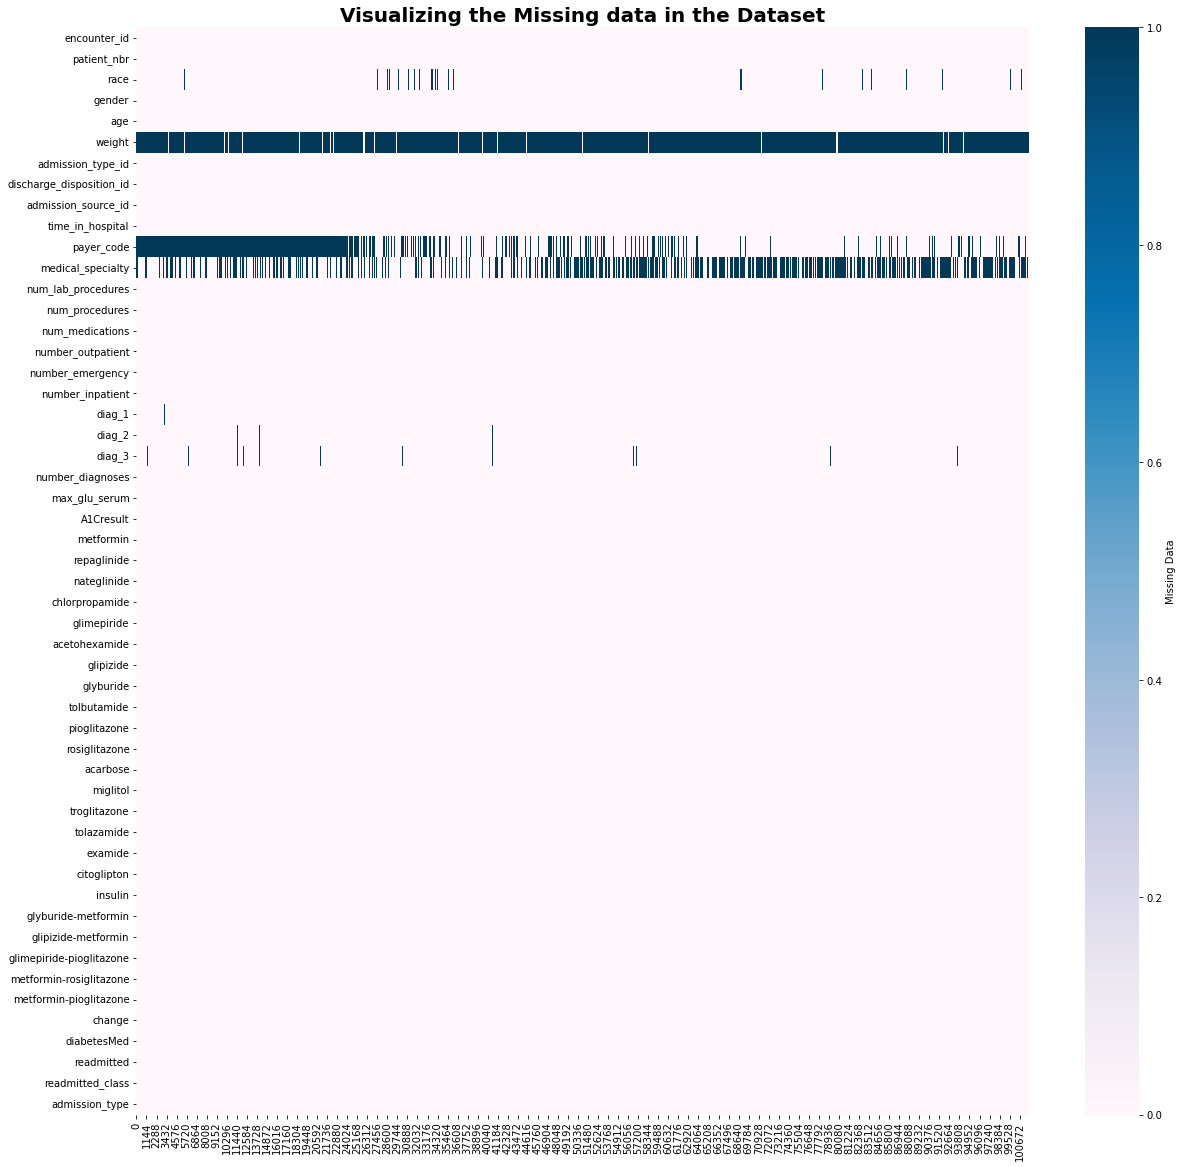

In [35]:
plt.figure(figsize = (20, 20))
sns.heatmap(df.eq('?').transpose(),
            cmap = "PuBu",
            cbar_kws = {'label' : 'Missing Data'})
plt.title("Visualizing the Missing data in the Dataset",
          fontsize = 20, fontweight = "bold")
plt.show()

We observe that the weight column has more than 95% missing data and medical specialty has almost 50% missing data. Hence, we drop these 2 columns.

In [25]:
#drop the weight and medical specialty column
df.drop(columns = ['weight','medical_specialty'], inplace = True)

In [29]:
#drop payer code column
df.drop(columns = ['payer_code'], inplace = True)

Next, we analyse the 'race' column that contains missing values.

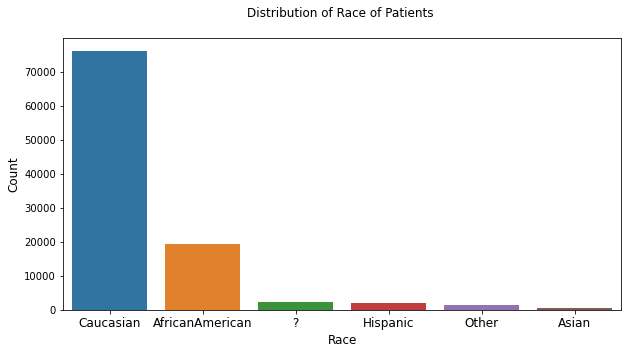

In [30]:
#plot a bar graph for race using seaborn
plt.figure(figsize = (10, 5))
ax = sns.barplot(x=df['race'].value_counts().index,   y=df['race'].value_counts())
plt.xlabel('Race', size = 12)
plt.xticks(size = 12)
plt.ylabel('Count', size = 12)
plt.title('Distribution of Race of Patients \n', size = 12)
plt.show()

A small portion of this column has missing data. Therefore, we impute the column and set the unknown values ‘?’ as ‘Other’ category.

In [31]:
df.loc[df['race'] == '?', 'race'] = 'Other'

Analyzing the diag_1, diag_2 and diag_3 columns now. These columns correspond to the primary diagnosis, secondary diagnosis and additional secondary diagnosis. These columns have been coded as first three digits of ICD9.

In [33]:
#rename diag_1, diag_2, diag_3 columns as primary_diagnosis, secondary_diagnosis, additional_diagnosis
df.rename(columns = {'diag_1':'primary_diagnosis',
                     'diag_2':'secondary_diagnosis',
                     'diag_3':'additional_diagnosis'}, inplace = True)

In [34]:
#values of ? in these 3 columns
diag_missing = df[['primary_diagnosis', 'secondary_diagnosis', 'additional_diagnosis']].eq('?').sum()
diag_missing = pd.DataFrame(diag_missing)
diag_missing.columns = ['missing_count']
diag_missing

,missing_count
primary_diagnosis,21
secondary_diagnosis,358
additional_diagnosis,1423


The amount of missing values in these 3 columns is considerably very small as compared to the number of rows in our dataset. Hence, we drop the rows containing missing values in these columns.

In [35]:
print("Number of instances before dropping missing rows:",df.shape[0])

Number of instances before dropping missing rows: 101766


In [36]:
#drop diag_1, diag_2, diag_3 columns with ? values
df.drop(df[df['primary_diagnosis'] == '?'].index, inplace = True)
df.drop(df[df['secondary_diagnosis'] == '?'].index, inplace = True)
df.drop(df[df['additional_diagnosis'] == '?'].index, inplace = True)

In [37]:
print("Number of instances after dropping missing rows",df.shape[0])

Number of instances after dropping missing rows 100244


**Data Processing**

We have 24 features that showcase the medications given to the patient while being admitted in the hospital. It includes the medications given in the below table. These features indicate whether the drug was prescribed or there was a change in the dosage.

The values that they hold are “up” if the dosage was increased during the encounter, “down” if the dosage was decreased, “steady” if the dosage did not change, and “no” if the drug was not prescribed.

|  |  |  |  |
| -- | -- | -- | -- |
|metformin|repaglinide|nateglinide|chlorpropamide|
|glimepiride|acetohexamide|glipizide|glyburide|
|tolbutamide|pioglitazone|rosiglitazone|acarbose|
|miglitol|troglitazone|tolazamide|examide|
|citoglipton|insulin|glyburide-metformin|glipizide-metformin|
|glimepiride-pioglitazone|metformin-rosiglitazone|metformin-pioglitazone|

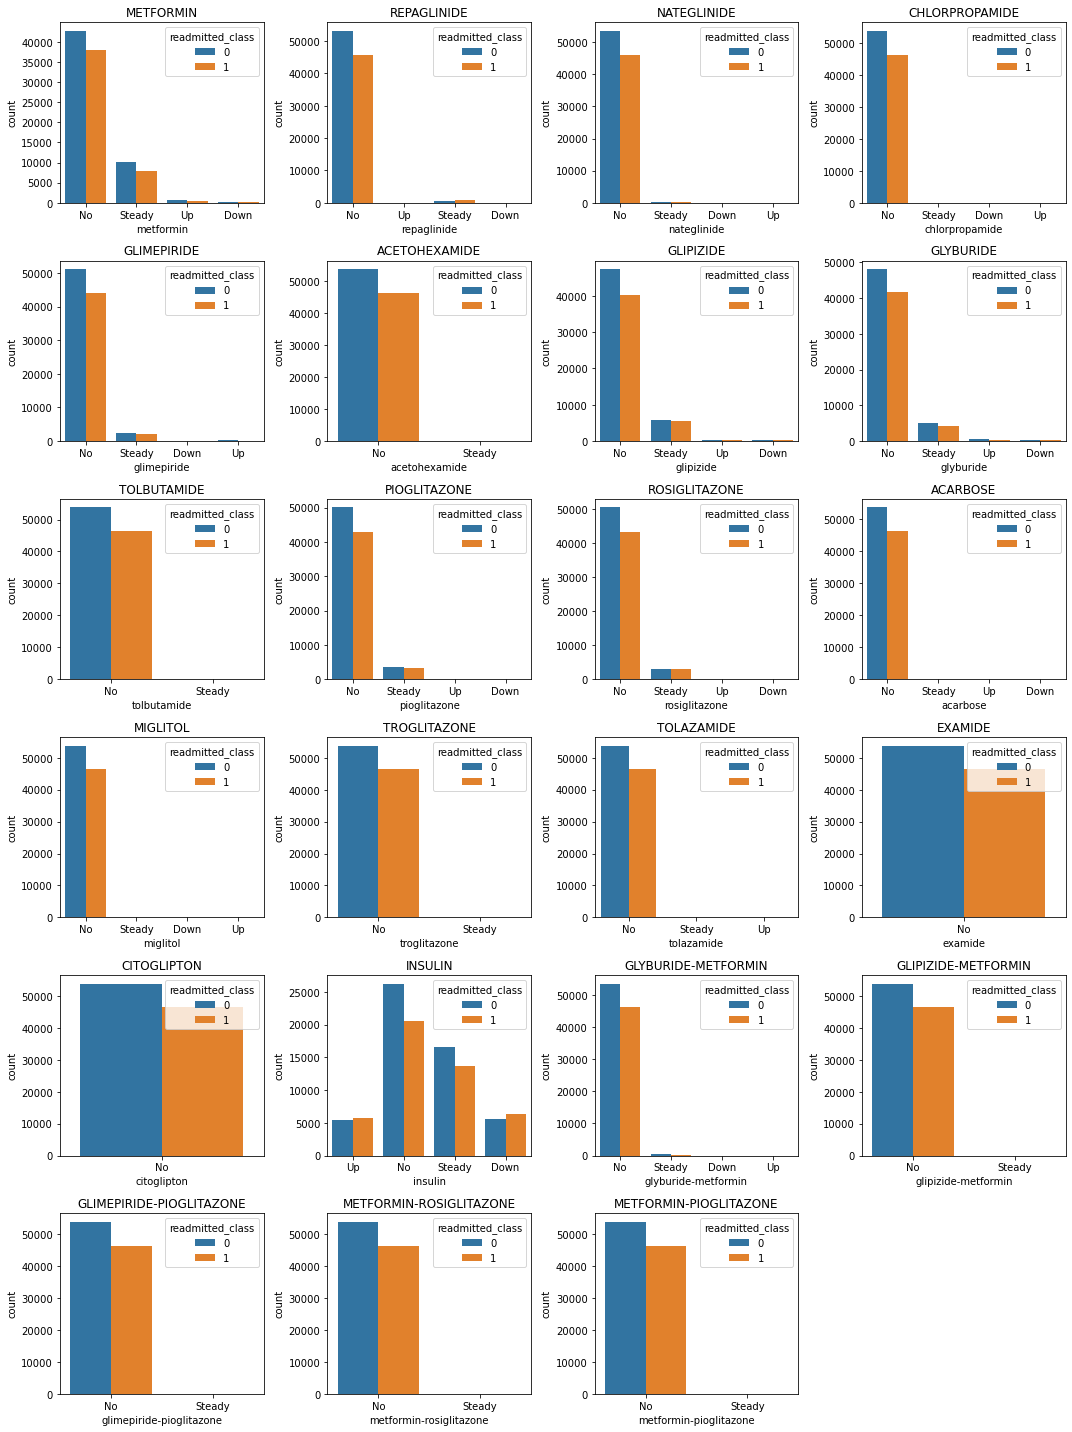

In [39]:
#plot subplots of countplot using seaborn for columns in 21 to 44 index vs readmitted_class
warnings.filterwarnings("ignore")
plt.figure(figsize = (15, 20))
for n, ticker in enumerate(df.columns[21:44]):
    ax = plt.subplot(6, 4, n + 1)
    ax = sns.countplot(df[ticker], hue=df['readmitted_class'])
    ax.set_title(ticker.upper(), fontsize = 12)
    plt.tight_layout()
plt.show()

In [41]:
df.drop(columns = ['acetohexamide', 'tolbutamide', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
                   'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone',
                   'metformin-pioglitazone'], inplace = True)

In [42]:
df['gender'].value_counts()

Female             53922
Male               46319
Unknown/Invalid        3
Name: gender, dtype: int64

In [43]:
df.drop(df[df['gender'] == 'Unknown/Invalid'].index, inplace = True)
df.reset_index(inplace = True, drop = True)

**Data Encoding**

Since we are dealing with categorical columns in our dataset, we map these unique values into numerical values as few Machine Learning models can only deal with numeric data. All of the categorical columns present in our dataset have ordinal categories i.e., they do not have any particular order.

In [45]:
categorical_features =['race', 'gender', 'age',
                       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
                       'primary_diagnosis', 'secondary_diagnosis', 'number_diagnoses',
                       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
                       'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide',
                       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin',
                       'glyburide-metformin', 'change', 'diabetesMed'] 

In [46]:
df2 = df.copy()

In this case, we have used Label encoding for the categorical columns.

In [47]:
#convert categorical features using label encoder
for feature in categorical_features:
    le = LabelEncoder()
    df2[feature] = le.fit_transform(df2[feature])

In [48]:
df2.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,rosiglitazone,acarbose,miglitol,insulin,glyburide-metformin,change,diabetesMed,readmitted,readmitted_class,admission_type
0,149190,55629189,2,0,1,0,0,6,3,59,...,1,1,1,3,1,0,1,>30,1,Emergency
1,64410,86047875,0,0,2,0,0,6,2,11,...,1,1,1,1,1,1,1,NO,0,Emergency
2,500364,82442376,2,1,3,0,0,6,2,44,...,1,1,1,3,1,0,1,NO,0,Emergency
3,16680,42519267,2,1,4,0,0,6,1,51,...,1,1,1,2,1,0,1,NO,0,Emergency
4,35754,82637451,2,1,5,1,0,1,3,31,...,1,1,1,2,1,1,1,>30,1,Urgent


In [49]:
df2.drop('admission_type',axis=1,inplace=True)

df2.drop('readmitted',axis=1,inplace=True)

df2.drop('encounter_id',axis=1,inplace=True)
df2.drop('patient_nbr',axis=1,inplace=True)

In [50]:
df2.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,glyburide,pioglitazone,rosiglitazone,acarbose,miglitol,insulin,glyburide-metformin,change,diabetesMed,readmitted_class
0,2,0,1,0,0,6,3,59,0,18,...,1,1,1,1,1,3,1,0,1,1
1,0,0,2,0,0,6,2,11,5,13,...,1,1,1,1,1,1,1,1,1,0
2,2,1,3,0,0,6,2,44,1,16,...,1,1,1,1,1,3,1,0,1,0
3,2,1,4,0,0,6,1,51,0,8,...,1,1,1,1,1,2,1,0,1,0
4,2,1,5,1,0,1,3,31,6,16,...,1,1,1,1,1,2,1,1,1,1


**Correlation Analysis**

Correlation analysis is performed as part of dimension reduction, where we calculate the correlation between every 2 numerical columns using Pearson’s coefficient. Pearson’s correlation coefficient is a bivariate correlation that measures the linear correlation between two sets of data, whose value ranges from -1 to 1. Essentially, it is a normalized measurement of their covariances. If a pair of variables are highly correlated (for example, setting 0.8 as the cutoff for highly correlated variables), then we drop one of the column-pair.

In [51]:
#correlation between numerical features
df_corr = df2[['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 
   'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']].corr()
df_corr

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
time_in_hospital,1.000000,0.319328,0.189262,0.463840,-0.010366,-0.010421,0.072412,0.210353
num_lab_procedures,0.319328,1.000000,0.058283,0.268948,-0.007713,-0.002240,0.038665,0.151184
num_procedures,0.189262,0.058283,1.000000,0.383102,-0.026398,-0.038563,-0.067989,0.060142
num_medications,0.463840,0.268948,0.383102,1.000000,0.043229,0.012260,0.061969,0.244153
number_outpatient,-0.010366,-0.007713,-0.026398,0.043229,1.000000,0.091531,0.107052,0.092965
number_emergency,-0.010421,-0.002240,-0.038563,0.012260,0.091531,1.000000,0.267318,0.055976
number_inpatient,0.072412,0.038665,-0.067989,0.061969,0.107052,0.267318,1.000000,0.102597
number_diagnoses,0.210353,0.151184,0.060142,0.244153,0.092965,0.055976,0.102597,1.000000


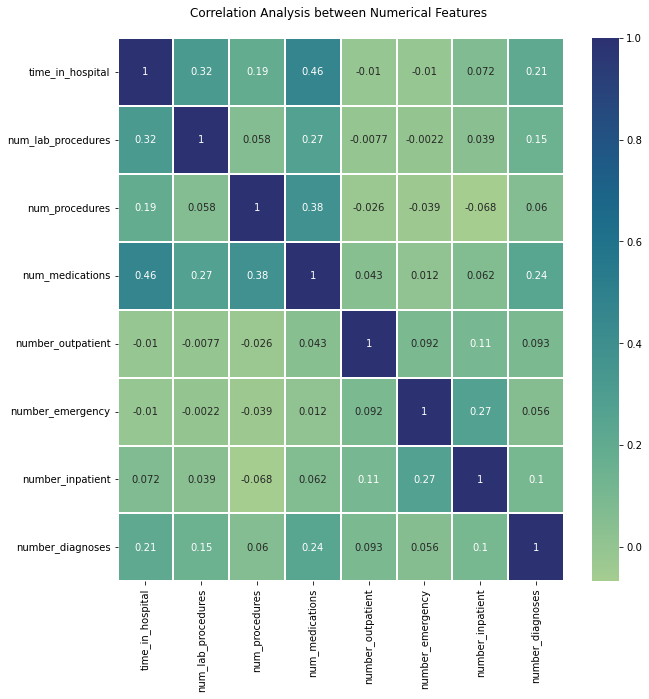

In [52]:
#generate a heat map to show correlation between numerical features
plt.figure(figsize=(10,10))
sns.heatmap(df_corr,annot=True,cmap='crest',linewidths=0.1)
fig=plt.gcf()
plt.title("Correlation Analysis between Numerical Features \n")
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [53]:
#drop additional diagnosis column
df2.drop('additional_diagnosis',axis=1,inplace=True)

In [54]:
#find the duplicate row in df2
duplicateRowsDF = df2[df2.duplicated()]
print(df2.shape)

(100241, 34)


**Feature Engineering**

This methodology is used to extract or derive new features from existing data using domain knowledge. Here, we have used this technique to come up with new columns that includes: <br>
1. Total hospital visits = number of outpatient visits + number of emergency visits + number of inpatient visits
2. Total medications = number of medications given + number of diagnoses
3. Total procedures completed = number of lab procedures + number of other procedures
4. Total diagnoses = number of diagnoses + number of inpatient visits

In [55]:
#perform feature engineering on df2
df2['total_visits'] = df2['number_outpatient'] + df2['number_emergency'] + df2['number_inpatient']
df2['total_medications'] = df2['num_medications'] + df2['number_diagnoses']
df2['total_procedures'] = df2['num_procedures'] + df2['num_lab_procedures']
df2['total_diagnoses'] = df2['number_diagnoses'] + df2['number_inpatient']

In [56]:
df2[['total_visits', 'total_medications', 'total_procedures', 'total_diagnoses']].head()

,total_visits,total_medications,total_procedures,total_diagnoses
0,0,24,59,6
1,3,16,16,4
2,0,20,45,4
3,0,10,51,2
4,0,22,37,6


In [57]:
#drop the columns that are no longer needed
df2.drop('number_outpatient',axis=1,inplace=True)
df2.drop('number_emergency',axis=1,inplace=True)
df2.drop('number_inpatient',axis=1,inplace=True)
df2.drop('num_medications',axis=1,inplace=True)
df2.drop('num_procedures',axis=1,inplace=True)
df2.drop('num_lab_procedures',axis=1,inplace=True)
df2.drop('number_diagnoses',axis=1,inplace=True)

In [58]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100241 entries, 0 to 100240
Data columns (total 31 columns):
 #   Column                    Non-Null Count   Dtype
---  ------                    --------------   -----
 0   race                      100241 non-null  int64
 1   gender                    100241 non-null  int64
 2   age                       100241 non-null  int64
 3   admission_type_id         100241 non-null  int64
 4   discharge_disposition_id  100241 non-null  int64
 5   admission_source_id       100241 non-null  int64
 6   time_in_hospital          100241 non-null  int64
 7   primary_diagnosis         100241 non-null  int64
 8   secondary_diagnosis       100241 non-null  int64
 9   max_glu_serum             100241 non-null  int64
 10  A1Cresult                 100241 non-null  int64
 11  metformin                 100241 non-null  int64
 12  repaglinide               100241 non-null  int64
 13  nateglinide               100241 non-null  int64
 14  chlorpropamide      

In [59]:
#convert dtype of df2 to float64
df2 = df2.astype('float64')

**Data Scaling/ Normalization**

The goal of this step is to bring all the features to a similar scale. This is an important step since it ensures equal consideration of all the features, thus improving the numerical stability of our model.

In [60]:
#normalize the numerical features
df2[['time_in_hospital', 'total_visits',
     'total_medications', 'total_procedures',
     'total_diagnoses']] = preprocessing.normalize(df2[['time_in_hospital', 'total_visits',
                                                        'total_medications', 'total_procedures',
                                                        'total_diagnoses']])
df2.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,primary_diagnosis,secondary_diagnosis,max_glu_serum,...,miglitol,insulin,glyburide-metformin,change,diabetesMed,readmitted_class,total_visits,total_medications,total_procedures,total_diagnoses
0,2.0,0.0,1.0,0.0,0.0,6.0,0.046841,143.0,78.0,2.0,...,1.0,3.0,1.0,0.0,1.0,1.0,0.00000,0.374726,0.921201,0.093681
1,0.0,0.0,2.0,0.0,0.0,6.0,0.085987,454.0,77.0,2.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.12898,0.687894,0.687894,0.171973
2,2.0,1.0,3.0,0.0,0.0,6.0,0.040447,554.0,96.0,2.0,...,1.0,3.0,1.0,0.0,1.0,0.0,0.00000,0.404474,0.910066,0.080895
3,2.0,1.0,4.0,0.0,0.0,6.0,0.019224,54.0,23.0,2.0,...,1.0,2.0,1.0,0.0,1.0,0.0,0.00000,0.192237,0.980407,0.038447
4,2.0,1.0,5.0,1.0,0.0,1.0,0.068861,263.0,245.0,2.0,...,1.0,2.0,1.0,1.0,1.0,1.0,0.00000,0.504980,0.849285,0.137722


**Data Partitioning**

Data partitioning or data splitting is the process of dividing the dataset into 2 or more parts, typically to train the model on one part and validate on the other. This step is performed to avoid overfitting.

In [61]:
df2.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,primary_diagnosis,secondary_diagnosis,max_glu_serum,...,miglitol,insulin,glyburide-metformin,change,diabetesMed,readmitted_class,total_visits,total_medications,total_procedures,total_diagnoses
0,2.0,0.0,1.0,0.0,0.0,6.0,0.046841,143.0,78.0,2.0,...,1.0,3.0,1.0,0.0,1.0,1.0,0.00000,0.374726,0.921201,0.093681
1,0.0,0.0,2.0,0.0,0.0,6.0,0.085987,454.0,77.0,2.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.12898,0.687894,0.687894,0.171973
2,2.0,1.0,3.0,0.0,0.0,6.0,0.040447,554.0,96.0,2.0,...,1.0,3.0,1.0,0.0,1.0,0.0,0.00000,0.404474,0.910066,0.080895
3,2.0,1.0,4.0,0.0,0.0,6.0,0.019224,54.0,23.0,2.0,...,1.0,2.0,1.0,0.0,1.0,0.0,0.00000,0.192237,0.980407,0.038447
4,2.0,1.0,5.0,1.0,0.0,1.0,0.068861,263.0,245.0,2.0,...,1.0,2.0,1.0,1.0,1.0,1.0,0.00000,0.504980,0.849285,0.137722


In [62]:
#split the data into train and test
X = df2.drop('readmitted_class',axis=1)
y = df2['readmitted_class']

In [63]:
#split the dataset into train, validation and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [64]:
#shape of train and test
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(80192, 30)
(80192,)
(20049, 30)
(20049,)


|Train Set|||
| -- | -- | -- |
|X_train|80192|30|
|y_train|80192|1|

|Test Set|||
| -- | -- | -- |
|X_test|20049|30|
|y_test|20049|1|

## Model Building and Model Selection

Since we have a classification problem, we have explored different classification models including logistic regression, naive bayes and support vector machines. We choose the model that performs the best on the dataset, and finally assess the performance of the chosen model.

### Logistic Regression

Logistic regression is a classification model which uses a set of features to predict a categorical outcome variable. It applies the logistic sigmoid function to weighted input values to generate a prediction of the data class.
<br><br>
We chose this model as our base model against which all other models will be compared. This model is chosen because it can interpret the model coefficients as indicators of feature importance, it performs well when the dataset is linearly separable.

In [108]:
class LogisticRegression :
    def __init__(self, maxIteration, tolerance, learningRate, index=[]):
        self.learningRate = learningRate
        self.maxIteration = maxIteration
        self.tolerance = tolerance
        self.index = index
        
    def readDataset(self):
        X_train.to_numpy, X_test.to_numpy, y_train.to_numpy, y_test.to_numpy = X_train, X_test, y_train, y_test
        return X_train, X_test, y_train, y_test
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def costFunction (self, X, y):
        
        #approach1
        sig = self.sigmoid(X.dot(self.w))
        cost = -(y * np.log(sig) + (1-y)*np.log(1-sig)).sum()
        cost = cost/X.shape[0]
        
        #approach2
        cost = (np.log(np.ones(X.shape[0]) + np.exp(X.dot(self.w))) - X.dot(self.w).dot(y)).sum()
        return cost
        
    def gradient(self, X, y):
        sig = self.sigmoid(X.dot(self.w))
        grad = (sig - y).dot(X)
        return grad
    
    def gradientDescent(self,X ,y):
        
        errors = []
        last_error = float('inf')
        
        for i in tqdm(range(self.maxIteration)):
            self.w = self.w - self.learningRate * self.gradient(X, y)
            current_error = self.costFunction(X, y)
            
            errors.append(current_error)
            diff = last_error - current_error
            last_error = current_error
            
            if np.abs(diff) < self.tolerance:
                print('model stopped learning')
                break 
        
        self.plotCost(errors)
        return errors
    
    def plotCost(self, errors):
        plt.figure(figsize = (12, 8))
        plt.plot(errors)
        plt.xlabel('Iterations')
        plt.ylabel('Error')
        plt.title('Cost Sequence Plot')
        plt.show()
        
    def fit(self):
        self.X_train, self.X_test, self.y_train, self.y_test = self.readDataset()
        
        #removing specified indexes
        
        if len(self.index) != 0 and self.X_train.shape[0] >= max(self.index, default = 0):
            print('removing specified indexes')
            self.remove_index()
        else:
            print('no records to drop for specified indexes')
                
        print('solving using gradient descent')
        
        self.w = np.zeros(self.X_train.shape[1], dtype = np.float64)
        self.gradientDescent(self.X_train, self.y_train)
        
        print('Model Coefficients are:\n',self.w)
        
        y_hat_train = self.predict(self.X_train)
        y_hat_test = self.predict(self.X_test)
        accuracy_train, precision_train, recall_train, bias_train, variance_train = self.evaluate(self.y_test,
                                                                                                  y_hat_test)
        accuracy_test, precision_test, recall_test, bias_test, variance_test = self.evaluate(self.y_test,
                                                                                                  y_hat_test)
        print('For the training set\n')
        print('accuracy is ', accuracy_train)
        print('precision is ', precision_train)
        print('recall is ', recall_train)
        
        print('For the test set\n')
        print('accuracy is ', accuracy_test)
        print('precision is ', precision_test)
        print('recall is ', recall_test)
        
        print('bias is ', bias_train)
        print('variance is ', variance_train)
        
        # self.plotost(self.errors)
    
    def remove_index(self):
        for index in self.index:
            self.X_train = np.delete(self.X_train, index, axis = 0)
            self.y_train = np.delete(self.y_train, index, axis = 0)
    
    def predict(self, X):
        sig = self.sigmoid(X.dot(self.w))
        return np.around(sig)
        
    def evaluate(self, y, y_hat):
        y = (y == 1)
        y_hat = (y_hat == 1)
        print(y.dtype)
        print(y_hat.dtype)
        recall = (y & y_hat).sum() / y.sum()
        precision = (y & y_hat).sum() / y_hat.sum()
        accuracy = (y == y_hat).sum() / y.size

        #covert bool to numpy array
        y = np.array(y)
        y_hat = np.array(y_hat)
        bias = np.mean(y_hat) - np.mean(y)
        variance = np.mean((y.astype(int)-y_hat.astype(int))**2).sum()
        
        return accuracy, precision, recall, bias, variance
    
    def plot(self, col1: str, col2: str):
        
        plt.figure(figsize=(12, 8))
        ax = plt.axes(projection='3d')

        # Data for three-dimensional scattered points
        ax.scatter3D(self.X_test[col1], self.X_test[col2], 
                     self.sigmoid(self.X_test.dot(self.w)), 
                     c = self.y_test[:], cmap='viridis', s=100)

        
        plt.xlabel(f'{col1} feature', fontsize=15)
        plt.ylabel(f'{col2} feature', fontsize=15, )
        ax.set_zlabel('$P(Y = 1|x_1, x_2)$', fontsize=15, rotation = 0)

    def getPlotData(self):
        return self.X_test, self.y_test, self.sigmoid(self.X_test.dot(self.w))
    
    def scatterPlt(self):
        # evenly sampled points
        x_min, x_max = 55, 80
        y_min, y_max = 80, 240

        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 250),
                             np.linspace(y_min, y_max, 250))
        grid = np.c_[xx.ravel(), yy.ravel()]
        probs = grid.dot(self.w).reshape(xx.shape)

        f, ax = plt.subplots(figsize=(14,12))

        ax.contour(xx, yy, probs, levels=[0.5], cmap="Greys", vmin=0, vmax=.6)

        print(self.X_test[:, 0])
        ax.scatter(self.X_test[:, 0], self.X_test[:, 1], 
                   c=self.y_test[:], s=50,
                   cmap="RdBu", vmin=-.2, vmax=1.2,
                   edgecolor="white", linewidth=1)

        plt.xlabel('x1 feature')
        plt.ylabel('x2 feature')     

    def plot3D(self, col1: str, col2: str):
        # evenly sampled points
        x_min, x_max = 55, 80
        y_min, y_max = 80, 240
        
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 250),
                             np.linspace(y_min, y_max, 250))
        
        grid = np.c_[xx.ravel(), yy.ravel()]
        probs = grid.dot(self.w)
        probs = probs.reshape(xx.shape)

        f, ax = plt.subplots(figsize=(14,12))

        ax.contour(xx, yy, probs, levels=[0.5], cmap="Greys", vmin=0, vmax=.6)

        ax.scatter3D(self.X_test[col1], self.X_test[col2], 
                   c=self.y_test[:], s=50,
                   cmap="RdBu", vmin=-.2, vmax=1.2,
                   edgecolor="white", linewidth=1)

        ax.set_xlabel(col1)
        ax.set_ylabel(col2)
        ax.set_zlabel('probs')
        ax.set_title('3D contour')
        plt.show()

In [113]:
lr1 = LogisticRegression(learningRate=0.0000001, tolerance=0.0000001, maxIteration=100)
X_train, X_test, y_train, y_test = lr1.readDataset()

no records to drop for specified indexes
solving using gradient descent


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 108.11it/s]


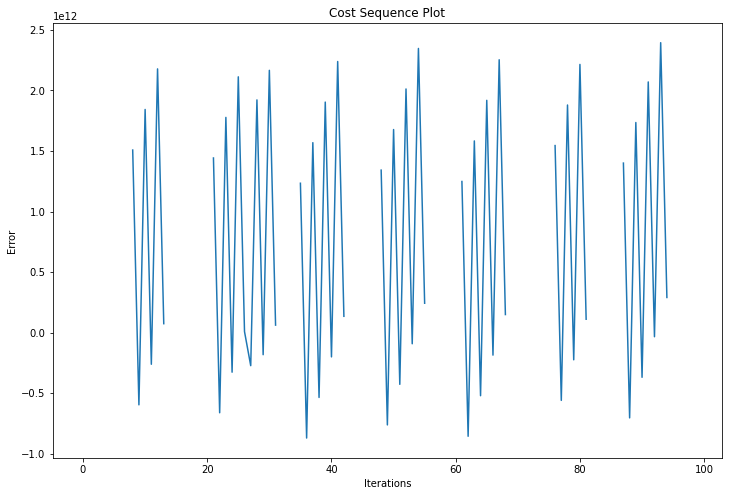

Model Coefficients are:
 race                       -0.000855
gender                     -0.002427
age                         0.032488
admission_type_id           0.001011
discharge_disposition_id   -0.026900
admission_source_id         0.074728
time_in_hospital            0.000825
primary_diagnosis           0.648970
secondary_diagnosis         0.594998
max_glu_serum               0.003487
A1Cresult                   0.004776
metformin                  -0.001907
repaglinide                 0.003583
nateglinide                 0.002686
chlorpropamide              0.002576
glimepiride                 0.002805
glipizide                   0.005006
glyburide                   0.001696
pioglitazone                0.003787
rosiglitazone               0.004015
acarbose                    0.002886
miglitol                    0.002546
insulin                     0.004567
glyburide-metformin         0.002764
change                     -0.007001
diabetesMed                 0.011750
total_visits 

In [114]:
lr1_starttime = time.time()
lr1.fit()
lr1_endtime = time.time()
lr1_elapsed_time = lr1_endtime - lr1_starttime
print('Execution time:', lr1_elapsed_time, 'seconds')

With this, we have obtained the following: <br>

|Accuracy|Precision|Recall|Execution Time
| -- | -- | -- | -- |
| 0.53 | 0.45 | 0.92 | 93 secs |

We can use the class's plot function to check the model's features (2 at a time, since the dataset is in higher dimension) in 3D space.

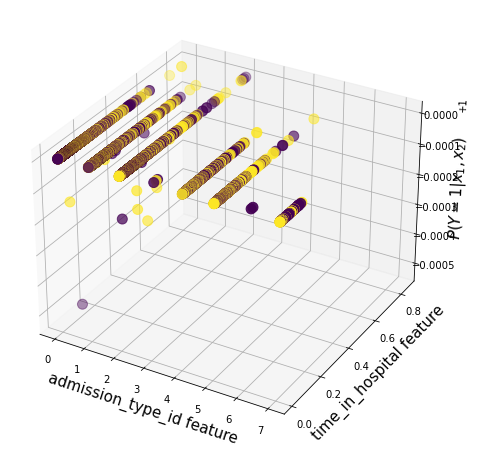

In [69]:
lr1.plot("admission_type_id", "time_in_hospital")

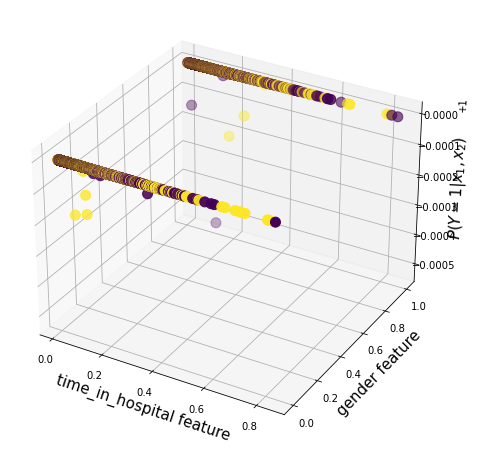

In [70]:
lr1.plot('time_in_hospital', 'gender')

**Hyperparameter Tuning**

In the logistic regression model, we have the learning rate (for gradient descent) and the tolerance (point at which the model stops learning) as the 2 hyperparameters. Typically, it is difficult to understand what hyperparameter values to take, therefore, we test the following set of parameters and compare them.
<br><br>

| Learning Rate | Tolerance | Accuracy | Precision | Execution Time |
| -- | -- | -- | -- | -- |
|0.0000001|0.0000001|45%|0.45|1.02 secs|
|0.000000001|0.001|46%|0.46|0.96 secs|

In [117]:
lr2 = LogisticRegression(learningRate=0.000000001, tolerance=0.001, maxIteration=100)
X_train, X_test, y_train, y_test = lr2.readDataset()

In [122]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
learningRate = ['0.0001', '0.00001', '0.000001', '0.0000001']
tolerance = []
maxIteration = []
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/Users/anshita.aishwarya/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/anshita.aishwarya/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

Best: 0.601753 using {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.601657 (0.004259) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.549329 (0.005004) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.601653 (0.004313) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.601594 (0.004235) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.549895 (0.003907) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.601753 (0.004331) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.601248 (0.004253) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.549526 (0.004598) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.601244 (0.004226) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.598601 (0.004205) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.549868 (0.004931) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.598501 (0.004215) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.584990 (0.004326) with

In [123]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
 
# Creating the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}
 
# Instantiating logistic regression classifier
logreg = LogisticRegression()
 
# Instantiating the GridSearchCV object
logreg_cv = GridSearchCV(logreg, param_grid, cv = 5)
 
logreg_cv.fit(X, y)
 
# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_))
print("Best score is {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameters: {'C': 0.05179474679231213}
Best score is 0.5476002155652411


no records to drop for specified indexes
solving using gradient descent


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 116.51it/s]


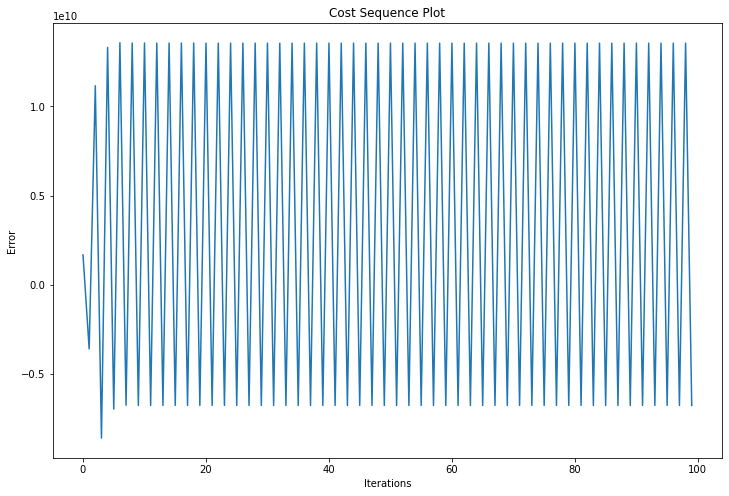

Model Coefficients are:
 race                        0.000059
gender                     -0.000003
age                         0.000567
admission_type_id           0.000047
discharge_disposition_id   -0.000184
admission_source_id         0.000957
time_in_hospital            0.000012
primary_diagnosis           0.003598
secondary_diagnosis         0.003782
max_glu_serum               0.000118
A1Cresult                   0.000125
metformin                   0.000032
repaglinide                 0.000079
nateglinide                 0.000070
chlorpropamide              0.000068
glimepiride                 0.000073
glipizide                   0.000098
glyburide                   0.000064
pioglitazone                0.000083
rosiglitazone               0.000086
acarbose                    0.000072
miglitol                    0.000068
insulin                     0.000108
glyburide-metformin         0.000071
change                     -0.000050
diabetesMed                 0.000153
total_visits 

In [118]:
lr2_starttime = time.time()
lr2.fit()
lr2_endtime = time.time()
lr2_elapsed_time = lr2_endtime - lr2_starttime
print('Execution time:', lr2_elapsed_time, 'seconds')

### Naive Bayes with PCA

**Naive Bayes:**

The Naive Bayes classifier is a machine learning model grounded in the Bayes theorem, relying on probabilities. This classification approach is chosen for its speed and efficiency, providing accurate outcomes even with extensive datasets.

**Principal Component Analysis (PCA):**

PCA is a method employed to diminish the dimensionality of substantial datasets. This technique generates fresh uncorrelated variables that progressively maximize variance. Given our dataset's approximately 30 features, we explore the utilization of PCA to assess whether it enhances model performance compared to our baseline model.

In [73]:
df2.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,primary_diagnosis,secondary_diagnosis,max_glu_serum,...,miglitol,insulin,glyburide-metformin,change,diabetesMed,readmitted_class,total_visits,total_medications,total_procedures,total_diagnoses
0,2.0,0.0,1.0,0.0,0.0,6.0,0.046841,143.0,78.0,2.0,...,1.0,3.0,1.0,0.0,1.0,1.0,0.00000,0.374726,0.921201,0.093681
1,0.0,0.0,2.0,0.0,0.0,6.0,0.085987,454.0,77.0,2.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.12898,0.687894,0.687894,0.171973
2,2.0,1.0,3.0,0.0,0.0,6.0,0.040447,554.0,96.0,2.0,...,1.0,3.0,1.0,0.0,1.0,0.0,0.00000,0.404474,0.910066,0.080895
3,2.0,1.0,4.0,0.0,0.0,6.0,0.019224,54.0,23.0,2.0,...,1.0,2.0,1.0,0.0,1.0,0.0,0.00000,0.192237,0.980407,0.038447
4,2.0,1.0,5.0,1.0,0.0,1.0,0.068861,263.0,245.0,2.0,...,1.0,2.0,1.0,1.0,1.0,1.0,0.00000,0.504980,0.849285,0.137722


In [74]:
X_pca = df2.drop('readmitted_class',axis=1)
X_pca.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,primary_diagnosis,secondary_diagnosis,max_glu_serum,...,acarbose,miglitol,insulin,glyburide-metformin,change,diabetesMed,total_visits,total_medications,total_procedures,total_diagnoses
0,2.0,0.0,1.0,0.0,0.0,6.0,0.046841,143.0,78.0,2.0,...,1.0,1.0,3.0,1.0,0.0,1.0,0.00000,0.374726,0.921201,0.093681
1,0.0,0.0,2.0,0.0,0.0,6.0,0.085987,454.0,77.0,2.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.12898,0.687894,0.687894,0.171973
2,2.0,1.0,3.0,0.0,0.0,6.0,0.040447,554.0,96.0,2.0,...,1.0,1.0,3.0,1.0,0.0,1.0,0.00000,0.404474,0.910066,0.080895
3,2.0,1.0,4.0,0.0,0.0,6.0,0.019224,54.0,23.0,2.0,...,1.0,1.0,2.0,1.0,0.0,1.0,0.00000,0.192237,0.980407,0.038447
4,2.0,1.0,5.0,1.0,0.0,1.0,0.068861,263.0,245.0,2.0,...,1.0,1.0,2.0,1.0,1.0,1.0,0.00000,0.504980,0.849285,0.137722


In [75]:
y_pca = df2['readmitted_class']
y_pca.head()

0    1.0
1    0.0
2    0.0
3    0.0
4    1.0
Name: readmitted_class, dtype: float64

In [76]:
#perform prinicpal component analysis on df2
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_pca)
principalDf = pd.DataFrame(data = principalComponents
              , columns = ['principal component 1', 'principal component 2'])

In [77]:
finalDf = pd.concat([principalDf, df[['readmitted_class']]], axis = 1)

In [78]:
finalDf.head()

,principal component 1,principal component 2,readmitted_class
0,-253.649105,-113.252677,1
1,35.470387,-227.848077,0
2,135.496716,-246.710076,0
3,-356.591676,-131.919159,0
4,-80.910236,-1.660876,1


In [79]:
#percentage of variance explained by each of the selected components
pca.explained_variance_ratio_

array([0.53638225, 0.46265676])

In [80]:
class NaiveBayes:
  def __init__(self, X, y, laplace):
       self.X = X
       self.y = y
       self.laplace = laplace
       self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=1)
  
  def fit(self, X, y):
    self.X0_train = self.X_train[self.y_train == 0]
    self.X1_train = self.X_train[self.y_train == 1]
    self.X1_0_unique = len(np.unique(self.X0_train[:,0]))
    self.X2_0_unique = len(np.unique(self.X0_train[:,1]))
    self.X1_1_unique = len(np.unique(self.X1_train[:,0]))
    self.X2_1_unique = len(np.unique(self.X1_train[:,1]))

    self.y0_prior = len(self.X0_train) / len(self.X)
    self.y1_prior = len(self.X1_train) / len(self.X)
    self.prob_x10y0 = (len(self.X0_train[self.X0_train[:,0]==0]) +
                       self.laplace) / (len(self.X0_train) + self.X1_0_unique * self.laplace)
    self.prob_x20y0 = (len(self.X0_train[self.X0_train[:,-1]==0])  +
                       self.laplace) / (len(self.X0_train) + self.X2_0_unique * self.laplace)
    self.prob_x11y0 = (len(self.X0_train[self.X0_train[:,0]==1]) +
                       self.laplace) / (len(self.X0_train)  + self.X1_0_unique * self.laplace)
    self.prob_x21y0 = (len(self.X0_train[self.X0_train[:,-1]==1]) +
                       self.laplace) / (len(self.X0_train)  + self.X2_0_unique * self.laplace)

    self.prob_x10y1 = (len(self.X1_train[self.X1_train[:,0]==0])  +
                       self.laplace) / (len(self.X1_train) + self.X1_1_unique * self.laplace)
    self.prob_x20y1 = (len(self.X1_train[self.X1_train[:,-1]==0]) +
                       self.laplace) / (len(self.X1_train)+ self.X2_1_unique * self.laplace)
    self.prob_x11y1 = (len(self.X1_train[self.X1_train[:,0]==1]) +
                       self.laplace) / (len(self.X1_train)+ self.X1_1_unique * self.laplace)
    self.prob_x21y1 = (len(self.X1_train[self.X1_train[:,-1]==1]) +
                       self.laplace) / (len(self.X1_train)+ self.X2_1_unique * self.laplace)

  def predict(self):

    self.y_pred_test = []
    for i in range(len(self.X_test)):
      x1 = self.X_test[i][0]
      x2 = self.X_test[i][1]
      y0 = self.y0_prior * self.prob_x10y0 ** x1 * self.prob_x20y0 ** x2
      y1 = self.y1_prior * self.prob_x11y1 ** x1 * self.prob_x21y1 ** x2
      if y0 > y1:
        self.y_pred_test.append(0)
      else:
        self.y_pred_test.append(1)
    
    print("For the test set:\n")
    accuracy_test = accuracy_score(self.y_test, self.y_pred_test)
    print("Accuracy: ", accuracy_test)
    precision_test = precision_score(self.y_test, self.y_pred_test)
    print("Precision: ", precision_test)
    recall_test = recall_score(self.y_test, self.y_pred_test)
    print("Recall: ", recall_test)
    f1_test = f1_score(self.y_test, self.y_pred_test)
    print("F1: ", f1_test)
    
    return self.y_pred_test

In [81]:
X_naive = finalDf[["principal component 1","principal component 2"]]
y_naive = finalDf["readmitted_class"]

In [82]:
nb = NaiveBayes(X_naive.to_numpy(), y_naive.to_numpy(), laplace=1)
nb_starttime = time.time()
nb.fit(X_naive, y_naive)
nb_endtime = time.time()
nb_elapsed_time = nb_endtime - nb_starttime
print('Execution time:', nb_elapsed_time, 'seconds')

Execution time: 0.03057098388671875 seconds


In [83]:
nb.predict()

For the test set:

Accuracy:  0.4615691555688563
Precision:  0.4590493311478877
Recall:  0.9390006489292667
F1:  0.6166412159522711


[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


With this, we have obtained the following: <br>

|Accuracy|Precision|Recall|F1 score|Execution Time|
| -- | -- | -- | -- | -- |
| 0.45 | 0.45 | 0.93 | 0.61 | 0.03 secs |

### Support Vector Machines

It is mainly a classification model in which we plot each data item as a point in n-dimensional space and perform classification by finding the hyper-plane that differentiates the two classes well. We have chosen this model for our analysis as it is an effective algorithm in high dimensional spaces.
Since the computation time and complexity increases with the number of rows in the dataset, therefore in our case, we have used a sampled dataset of 500 records.

In [84]:
df3 = df2.sample(n = 500)

In [85]:
df3.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,primary_diagnosis,secondary_diagnosis,max_glu_serum,...,miglitol,insulin,glyburide-metformin,change,diabetesMed,readmitted_class,total_visits,total_medications,total_procedures,total_diagnoses
7612,2.0,1.0,6.0,1.0,0.0,0.0,0.108485,263.0,384.0,2.0,...,1.0,2.0,1.0,1.0,1.0,0.0,0.00000,0.501744,0.854321,0.081364
11810,0.0,0.0,6.0,0.0,0.0,6.0,0.062584,412.0,79.0,2.0,...,1.0,0.0,1.0,0.0,1.0,1.0,0.00000,0.438089,0.891823,0.093876
16433,2.0,1.0,5.0,0.0,0.0,6.0,0.071429,325.0,103.0,2.0,...,1.0,2.0,1.0,1.0,1.0,0.0,0.00000,0.271429,0.957143,0.071429
12599,2.0,1.0,7.0,0.0,17.0,6.0,0.085749,276.0,101.0,2.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.01715,0.171499,0.977542,0.085749
90424,2.0,0.0,8.0,0.0,0.0,6.0,0.069864,361.0,385.0,2.0,...,1.0,0.0,1.0,0.0,1.0,1.0,0.00000,0.436652,0.890770,0.104796


In [86]:
df3.loc[ df3['readmitted_class'] == 0, 'readmitted_class'] = -1

In [87]:
scaled_X_train_svm = preprocessing.StandardScaler().fit_transform(df3)

In [88]:
X_svm = df3.drop('readmitted_class',axis=1)
y_svm = df3['readmitted_class']

In [90]:
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_svm, y_svm, test_size=0.2, random_state=101)

In [91]:
class MaxMarginClassifier:

    def __init__(self, C):
        self.C = C

    def fit(self, X, y):
        N = len(y)

        #GramXy
        Xy = X*y[:, np.newaxis] 

        GramXy = np.matmul(Xy, Xy.T)

        def Ld0(G, alpha):
            obj_fn = alpha.sum() - 0.5*alpha.dot(alpha.dot(G))
            return obj_fn

        def partialDerivationLd0(G, alpha):
            par_der = np.ones_like(alpha) - alpha.dot(G)
            return par_der

        alpha = np.ones(N)

        A = np.vstack((-np.eye(N), np.eye(N)))
        b = np.concatenate((np.zeros(N), self.C* np.ones(N)))

        constrains = ({'type' : 'eq', 'fun' : lambda a: np.dot(a,y),
                       'jac' : lambda a: y}, {'type': 'ineq', 'fun': lambda a: b - np.dot(A,a),
                         'jac': lambda a: -A})     

        optRes = optimize.minimize(fun = lambda a: -Ld0(GramXy, a), 
                                    x0 = alpha, 
                                    method = 'SLSQP', 
                                    jac = lambda a: -partialDerivationLd0(GramXy, a), 
                                    constraints= constrains)
        self.alpha = optRes.x
        self. w = np.sum((self.alpha[:, np.newaxis] * Xy), axis = 0)
        epsilon = 1e-4

        self.supportVectors = X[self.alpha > epsilon]
        self.supportLabels = y[self.alpha > epsilon]

        b = []
        for i in range(len(self.supportLabels)):
            b_i = self.supportLabels[i] - np.matmul(self.supportVectors[i].T, self.w)
            b.append(b_i)
        self.intercept = sum(b)/len(b)

    def predict(self, X):
        
        return 2*(np.matmul(X, self.w) + self.intercept > 0) - 1

    #find accuracy, precision, recall
    def evaluate(self, y, y_hat):
        y = (y == 1)
        y_hat = (y_hat == 1) 
        
        recall = np.sum(y & y_hat) / np.sum(y)
        precision = np.sum(y & y_hat) / np.sum(y_hat)

        accuracy = np.sum(y == y_hat) / len(y)
        return accuracy, precision, recall
        


In [92]:
model = MaxMarginClassifier(C=5)

In [93]:
svm_starttime = time.time()
model.fit(X_train_svm.to_numpy(), y_train_svm.to_numpy())
svm_endtime = time.time()
svm_elapsed_time = svm_endtime - svm_starttime
print('Execution time:', svm_elapsed_time, 'seconds')

Execution time: 19.34981608390808 seconds


In [94]:
model.w

array([-2.57246480e-01, -6.30115018e-01,  9.52625257e-03, -3.13998273e-02,
        7.33724717e-03,  4.89638325e-03,  1.66561083e+00, -1.72713528e-03,
        7.81994437e-04,  1.03454000e+00,  5.42753688e-01, -3.80311435e-01,
       -8.53587957e-01, -4.09009095e-01,  7.28793974e-01,  4.59213302e-02,
       -2.31764740e-02, -2.54115515e-01,  1.51178483e-02, -1.07583297e+00,
       -1.16113599e+00,  2.13162821e-14, -3.00139923e-01, -2.13401683e-01,
       -4.45622603e-01,  3.49593279e-01,  5.90835887e+00, -1.22288830e-02,
        1.13699178e+00,  6.32843334e+00])

In [95]:
model.intercept

-0.042979573234252874

In [96]:
model.supportVectors

array([[2.        , 0.        , 8.        , ..., 0.56758052, 0.80407241,
        0.14189513],
       [2.        , 0.        , 8.        , ..., 0.33992152, 0.93478418,
        0.08498038],
       [2.        , 1.        , 7.        , ..., 0.69052241, 0.63297887,
        0.3452612 ],
       ...,
       [0.        , 0.        , 3.        , ..., 0.20841376, 0.95870327,
        0.06947125],
       [2.        , 0.        , 7.        , ..., 0.57254511, 0.80903113,
        0.08712643],
       [0.        , 0.        , 4.        , ..., 0.28286609, 0.95145867,
        0.09000285]])

In [97]:
#classes
y_train_svm.unique()

array([ 1., -1.])

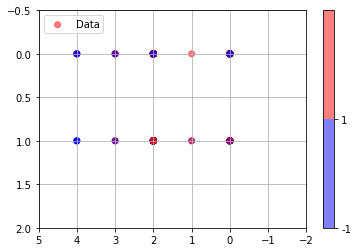

In [98]:
plotSvm(X_train_svm.to_numpy(), y_train_svm.to_numpy(), bound=[[5., -2.], [2., -.5]])

Number of support vectors = 325


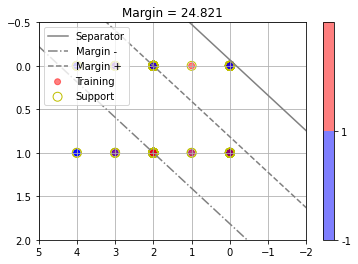

In [99]:
plotSvm(X_train_svm.to_numpy(), y_train_svm.to_numpy(), model.supportVectors, model.w,
        model.intercept, label = 'Training',bound=[[5., -2.], [2., -.5]])

In [100]:
y_predict_svm_train = model.predict(X_train_svm)

In [101]:
#print accuracy, precision, recall on train set
accuracy, precision, recall = model.evaluate(y_train_svm, y_predict_svm_train)
print("Training set:\n")
print('Accuracy: %.3f' % accuracy)
print('Precision: %.3f' % precision)
print('Recall: %.3f' % recall)

Training set:

Accuracy: 0.665
Precision: 0.639
Recall: 0.597


In [102]:
y_predict_svm_test = model.predict(X_test_svm)

Number of support vectors = 325


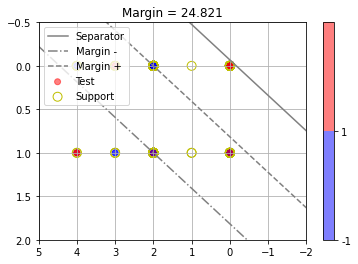

In [103]:
plotSvm(X_test_svm.to_numpy(), y_predict_svm_test.to_numpy(),
        model.supportVectors, model.w, model.intercept,
        label = 'Test',bound=[[5., -2.], [2., -.5]])

In [104]:
#print accuracy, precision, recall on test set
accuracy, precision, recall = model.evaluate(y_test_svm, y_predict_svm_test)
print("Test set:\n")
print('Accuracy: %.3f' % accuracy)
print('Precision: %.3f' % precision)
print('Recall: %.3f' % recall)

Test set:

Accuracy: 0.590
Precision: 0.450
Recall: 0.486


With this, we have obtained the following: <br>


||Accuracy|Precision|Recall|Execution Time|
| -- | -- | -- | -- | -- |
| Training | 0.66 | 0.63 | 0.59 | 19.83 secs |
| Test | 0.59 | 0.45 | 0.48 | 19.83 secs |

Even though, SVM is performing the best out of all the 3 models that we have explored, however the computation time is higher. Even when we sampled the dataset to 500 records, the time taken by SVM is around 20 seconds. If we take the complete dataset (~100k records), then the computation time would be much higher. This is not ideal.

Finally, we choose Logistic Regression as the best performing model with the following performance measures: <br>

|Accuracy|Precision|Recall|Execution Time
| -- | -- | -- | -- |
| 45% | 0.45 | 1 | 1.02 secs |

## Bias-Variance Tradeoff

The term 'bias' signifies the disparity between our model's average prediction and the actual value we intend to predict, leading to heightened errors in both training and test data. On the other hand, 'variance' reflects the variability in model predictions, showcasing data spread. Models with high variance excel in training but falter in test data. Overfitting occurs when a model captures both underlying patterns and noise, resulting in low bias and high variance. Conversely, underfitting arises when a model oversimplifies, struggling to grasp underlying data patterns, leading to high bias. The bias-variance trade-off underscores the importance of striking a balance in model performance to avoid overfitting or underfitting the data.

In our chosen model that is, Logistic Regression, we have calculated the bias and variance of the model as follows:
<br><br>

|Bias|Variance|
| -- | -- |
| 0.54 | 0.54 |

<br>
We observe that there is a proper balance between the 2 values, hence the model we have chosen is neither overfitting nor underfitting.